# About

This notebook is for the seminar 1. Here you will find tasks and all necessary information to complete them.

In [2]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

import os, sys
sys.path.append('../code')

## Generate events

This section shows how data sample with 2D straight track can be generated. The data sample consist of number of events. Each event is a set of hits. Some of the hits form track, but some of them are just noise hits.  

For the events generation a **straight_tracks_generator** function is used.

Parameters of the function:

**n_events**: int, number of generated events.

**n_tracks**: int, number of generated tracks in each event. Tracks will have TrackIDs in range [0, inf).

**n_noise**: int, number of generated random noise hits. Noise hits will have TrackID -1.

**sigma**: float, track's hit generated with error which has normal distribution.
              Sigma is parameter of the distribution.
              
**intersection**: booleen, if False the tracks will not intersect each other.

**x_range**: tuple (min, max, step), range of x values of the hits.

**y_range**: tuple (min, max, step), range of y values of the hits. Only for intersection=False.

**k_range**: tuple (min, max, step), range of k values of the track. y = b + k * x.

**b_range**: tuple (min, max, step), range of b values of the track. y = b + k * x.

In [2]:
from utils import straight_tracks_generator
events = straight_tracks_generator(n_events=10, n_tracks=3, n_noise=10, sigma=0.1)

events.head()

,EventID,TrackID,X,y
0,0,0,0,-8.265415
1,0,0,1,-9.714796
2,0,0,2,-11.054157
3,0,0,3,-12.658448
4,0,0,4,-13.826816


## Plot Tracks

Function **plot_straight_tracks** generates plot of an event with its tracks and noise hits.

Parameters of the function:

**event**: pandas.DataFrame with one event.

**labels**: numpy.array shape=[n_hits], labels of recognized tracks.

**return**: matplotlib.pyplot object.

In [3]:
event = events[events.EventID == 0]
X = event.X.values
y = event.y.values

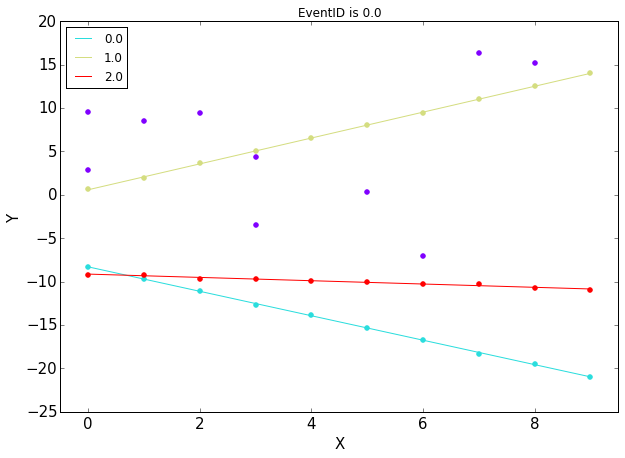

In [4]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels=None)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Tracks Recognition Methods

The following sections will introduce you with several method of the tracks recognition.

## Simple Template Matching

The **SimpleTemplateMatching** class is simple realization of a Template Matching paradigm for straight tracks in 2D.

Parameters:

**n_hits**: int, min number of hits to consider the track recognized.

**window_width**: float, width of a searching window for searching hits for a track.

In [5]:
from TemplateMatching import SimpleTemplateMatching

stm = SimpleTemplateMatching(8, 1.0)
stm.fit(X, y)

params = stm.tracks_params_
labels = stm.labels_

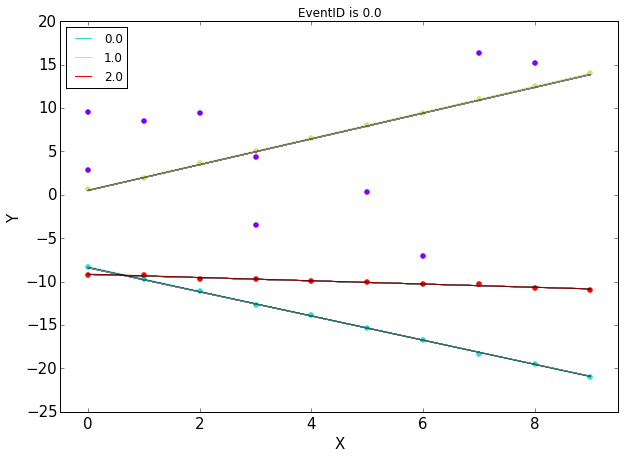

In [6]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# RANSAC

The **RANSAC** class is wrapper over the scikit-learn [RANSACRegressor](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html).

Parameters:

**sklearn_ransac**: a scikit-learn RANSACRegressor object.

In [7]:
from sklearn.linear_model import RANSACRegressor
from RANSAC import RANSAC

sk_ransac = RANSACRegressor(min_samples=3, max_trials=1000, residual_threshold=1.)
ransac = RANSAC(sklearn_ransac=sk_ransac)
ransac.fit(X, y)

labels = ransac.labels_

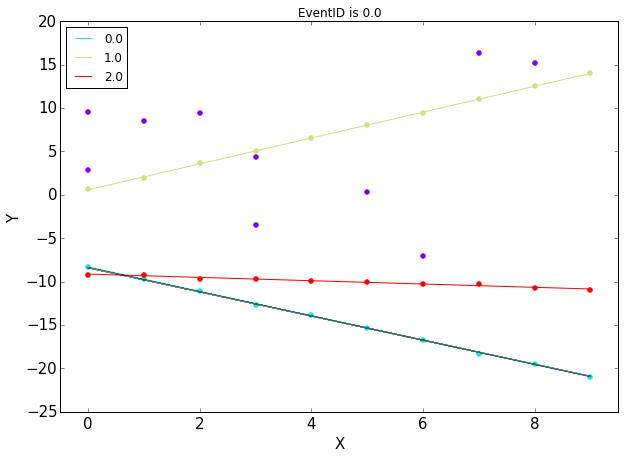

In [8]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Hough Transfrom

The **HoughLinear** class is realization of the Hough Transform for the straight tracks in 2D. y = kx + b.

**k_params**: tuple (min, max, n_bins), bins parameters for the k parameter.

**b_params**: tuple (min, max, n_bins), bins parameters for the b parameter.

**n_candidates**: int, number of tracks should be found.

**show**: boolean, if true, the histograms of the Hough Transform will be shown.

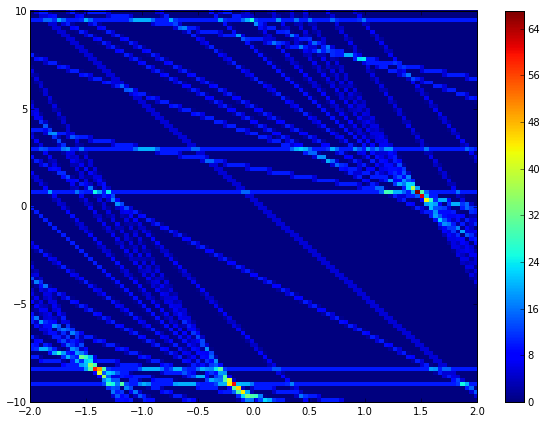

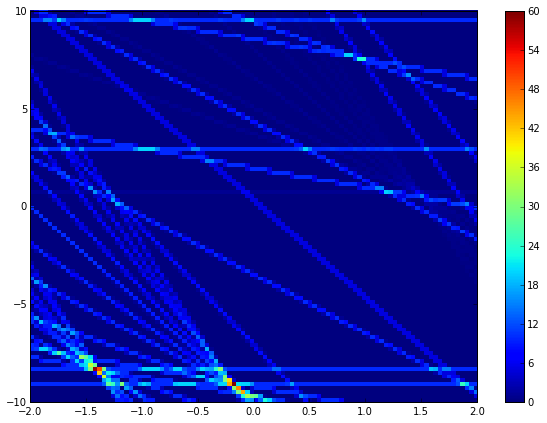

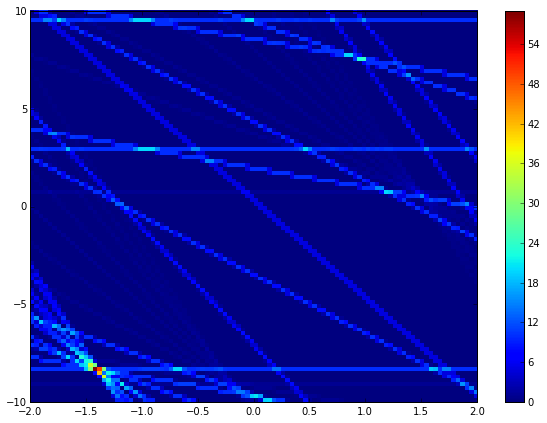

In [9]:
from hough import HoughLinear

hl = HoughLinear(k_params=(-2, 2, 100), b_params=(-10, 10, 100), n_candidates=3, show=True)
hl.fit(X, y, weights_mul=10)
labels = hl.labels_

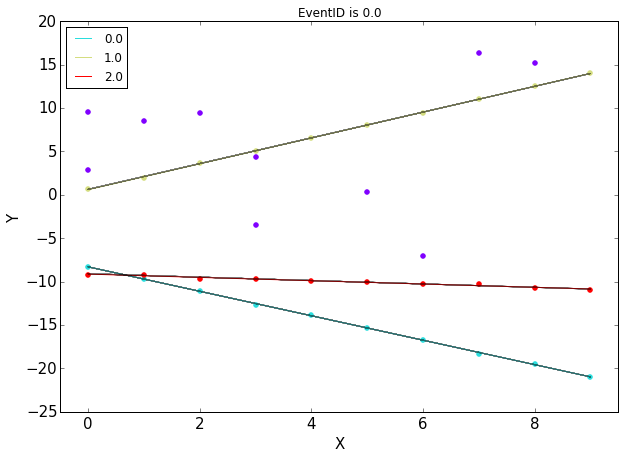

In [10]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# DenbyPeterson

The **DenbyPeterson** class is simple realization of the Denby-Peterson method of tracks recognition.

Parameters:

**n_iter**: int, number of iteration.

**cos_degree**: int, degree of the cos value for the angle between the two neurons.

**alpha**: float, multiplier of the penalty function against bifurcations.

**delta**: float, multiplier of the penalty function to balance number of active neurons against number of hits.

**temperature**: float, parameter in the neuron's state updating rule.

**temperature_decay_rate**: float, decay rate of the temperature during the network optimization.

**max_cos**: float, max cos value for the angle between the two neurons.
The neurons with larger values will be removed after the network optimization.

**state_threshold**: float, is sate of a neuron is greater than this value, the neuron will marked as active.

**min_hits**: int, min number of hits in a track candidate.

**save_stages**: boolean, if True, the neurons states will be saved after each iteration.

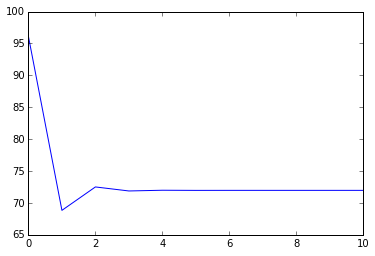

In [12]:
from DenbyPeterson import DenbyPeterson

dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1, 
                   alpha=0.00, 
                   delta=0.00, 
                   temperature=1, 
                   temperature_decay_rate=1., 
                   max_cos=-0.9,
                   state_threshold=0.5,
                   min_hits=3,
                   save_stages=True)
dp.fit(X, y)

satets = dp.states_
states_after_cut = dp.states_after_cut_
labels = dp.labels_


energy_stages = dp.energy_stages_
plt.plot(energy_stages)
plt.show()

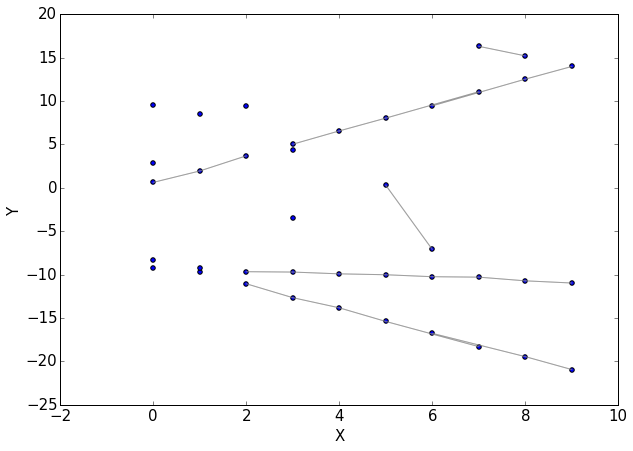

In [14]:
from DenbyPeterson import plot_neural_net

plot_neural_net(X, y, states_after_cut, 0.5)
plt.show()

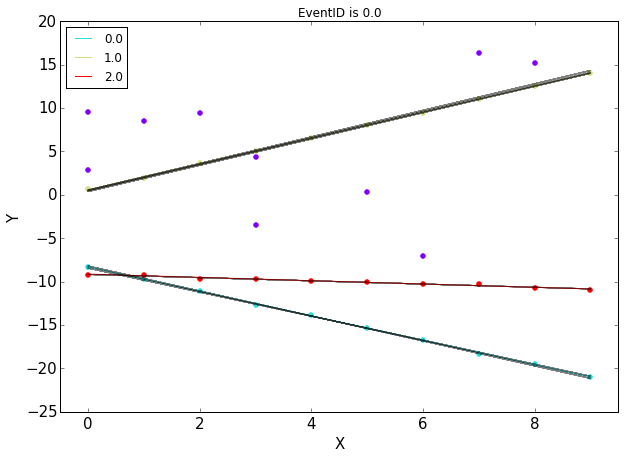

In [15]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Naive Track Following

The **LinearNaiveTrackFollowing** calss is simple realization of the Naive Track Following algorithm the straight track in 2D.

Parameters:

**window**: float, if the difference between a hit and the extrapolation function is larger than thi value,
the hit is rejected.

**min_hits**: int, min number of hits in a track.

**n_last_fit**: int, number of last point used for the extrapolation.

In [16]:
from LinearNaiveTrackFollowing import LinearNaiveTrackFollowing

lntf = LinearNaiveTrackFollowing(window=4, min_hits=4, n_last_fit='all')
lntf.fit(X, y)

labels = lntf.labels_
predictions = lntf.predictions_

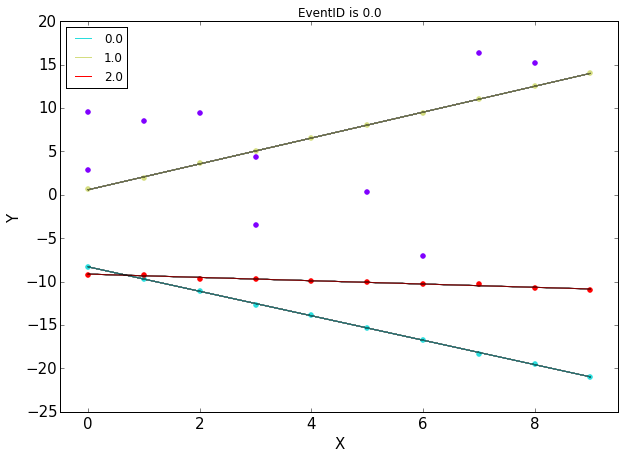

In [17]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# The Kalman Filter

The **LinearKalmanFilter** class is simple realization of the Kalman Filter model for the straight track in 2D.

Parameters:

**window**: float, if the difference between a hit and the extrapolation function is larger than thi value,
the hit is rejected.

**min_hits**: int, min number of hits in a track.

**initial_state_covariance**: numpy.matrix shape = [2,2], init state covariance.

**transition_covariance**: numpy.matrix shape = [2,2], transition covariance.

**observation_covariance**: numpy.matrix shape = [1,1], observation covariance.

In [19]:
from KalmanFilter import LinearKalmanFilter

transition_covariance= 0.000000001* numpy.eye(2)
observation_covariance = 0.0001* numpy.eye(1)
initial_state_covariance = 0.000001 * numpy.eye(2)


kf = LinearKalmanFilter(window=2, 
                        min_hits=4, 
                        initial_state_covariance = 0.000001 * numpy.eye(2),
                        transition_covariance=0.000000001* numpy.eye(2), 
                        observation_covariance=0.0001* numpy.eye(1))
kf.fit(X,y)

labels = kf.labels_
predictions = kf.predictions_
matrices = kf.matrices_

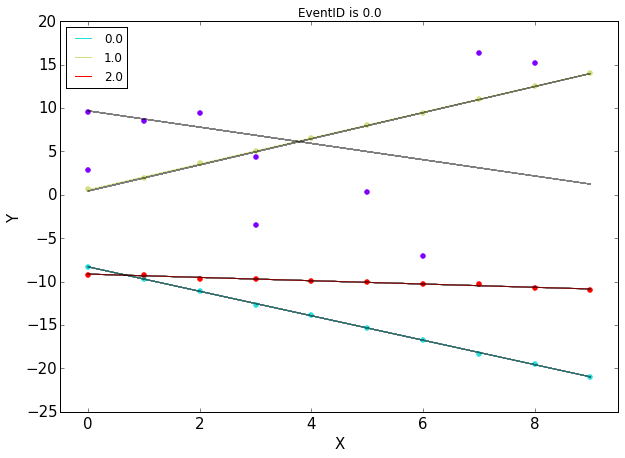

In [20]:
from utils import plot_straight_tracks
plot_straight_tracks(event, labels)
plt.xlim(-0.5, 9.5)
plt.ylabel('Y', size=15)
plt.xlabel('X', size=15)
plt.xticks(size=15)
plt.yticks(size=15)
plt.show()

# Quality Metrics

## Hits Matching

The **HitsMatchingEfficiency** class calculates tracks efficiencies, reconstruction efficiency, ghost rate and clone rate for one event using hits matching.

Parameters:

**eff_threshold**: float, threshold value of a track efficiency to consider a track reconstructed.

In [21]:
from metrics import HitsMatchingEfficiency

hme = HitsMatchingEfficiency()
hme.fit(event, labels)

print hme.efficiencies_
print hme.avg_efficiency_
print hme.recognition_efficiency_
print hme.ghost_rate_
print hme.clone_rate_

[ 1.          0.88888889  1.          0.6       ]
0.872222222222
1.0
0.333333333333
0.0


## Parameters Matching

The **ParameterMatchingEfficiency** class calculates tracks efficiencies, reconstruction efficiency, ghost rate and clone rate for one event using parameters matching.

Parameters:

**delta_k**: float, maximum abs difference between a true track k value and a recognized one to consider the track to be reconstructed.

**delta_b**: float, maximum abs difference between a true track b value and a recognized one to consider the track to be reconstructed.

In [22]:
from metrics import ParameterMatchingEfficiency

pme = ParameterMatchingEfficiency(delta_k = .2, delta_b=1.)
pme.fit(event, labels)

print pme.recognition_efficiency_
print pme.ghost_rate_
print pme.clone_rate_

1.0
0.333333333333
0.0


## Quality on all events

For the testing a method you can use the following function.

In [23]:
from copy import copy
from metrics import HitsMatchingEfficiency, ParameterMatchingEfficiency

def get_quality_meatrics(events, model):
    
    results = pandas.DataFrame(columns=['EventID', 'HmAvgEff',
                                    'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 
                                    'PmRecoEff', 'PmGhostRate', 'PmCloneRate'])

    for event_id in numpy.unique(events.EventID.values):

        event = events[events.EventID == event_id]
        x = event.X.values
        y = event.y.values
        
        model_object = copy(model)
        model_object.fit(x, y)
        labels = model_object.labels_

        hme = HitsMatchingEfficiency()
        hme.fit(event, labels)

        pme = ParameterMatchingEfficiency(delta_k = 0.4, delta_b=2.)
        pme.fit(event, labels)

        results.loc[len(results)] = [event_id, hme.avg_efficiency_, 
                                     hme.recognition_efficiency_, hme.ghost_rate_, hme.clone_rate_, 
                                     pme.recognition_efficiency_, pme.ghost_rate_, pme.clone_rate_]
        
    return results

In [24]:
results = get_quality_meatrics(events, model=stm)

In [25]:
results.head()

,EventID,HmAvgEff,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0,0.902778,1.000000,0,0,1.000000,0,0
1,1,0.717949,0.666667,0,0,0.666667,0,0
2,2,0.900000,1.000000,0,0,1.000000,0,0
3,3,0.969697,1.000000,0,0,1.000000,0,0
4,4,1.000000,1.000000,0,0,1.000000,0,0


In [26]:
results.mean(axis=0)

EventID        4.500000
HmAvgEff       0.907848
HmRecoEff      0.966667
HmGhostRate    0.000000
HmCloneRate    0.000000
PmRecoEff      0.966667
PmGhostRate    0.000000
PmCloneRate    0.000000
dtype: float64

# Tasks

In sections below you will find tasks and examples of how to do them.

Have fun!

## Supporting functions

You can use the following function for plotting your results.

In [27]:
def plot_report(report, x_column):

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 2)
    plt.plot(report[x_column].values, report['PmRecoEff'].values, linewidth=4, label='Reco Eff')
    plt.plot(report[x_column].values, report['PmGhostRate'].values, linewidth=4, label='Ghost Rate')
    plt.plot(report[x_column].values, report['PmCloneRate'].values, linewidth=4, label='Clone Rate')
    plt.legend(loc='best', prop={'size':12})
    plt.xlabel(x_column, size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title('Parameters Matching', size=12)
    
    plt.subplot(1, 2, 1)
    plt.plot(report[x_column].values, report['HmRecoEff'].values, linewidth=4, label='Reco Eff')
    plt.plot(report[x_column].values, report['HmGhostRate'].values, linewidth=4, label='Ghost Rate')
    plt.plot(report[x_column].values, report['HmCloneRate'].values, linewidth=4, label='Clone Rate')
    plt.legend(loc='best', prop={'size':12})
    plt.xlabel(x_column, size=12)
    plt.xticks(size=12)
    plt.yticks(size=12)
    plt.title('Hits Matching', size=12)
    
    plt.show()

## Task 1

The first task is to find optimal parameters for the five different tracks recognition models. Try to improve Reconstruction Efficiecies, reduce Ghost and Clone Rates. 

We recommend you firstly test your models just on one event on the cells above and only after that test them on the all events.

Please, take into account that the Denby-Peterson method takes a lot of time.

We intentionally set the wrong parameters, so you have all chances to improve the tracks recognition qualities for the all models.

In [28]:
from utils import straight_tracks_generator
events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=0.5)

In [29]:
from TemplateMatching import SimpleTemplateMatching
from hough import HoughLinear
from DenbyPeterson import DenbyPeterson
from LinearNaiveTrackFollowing import LinearNaiveTrackFollowing
from KalmanFilter import LinearKalmanFilter


stm = SimpleTemplateMatching(8, 0.1)
hl = HoughLinear(k_params=(-2, 2, 10), b_params=(-10, 10, 10), n_candidates=3, show=False)
dp = DenbyPeterson(n_iter=10, 
                   cos_degree=1, 
                   alpha=10.00, 
                   delta=10.00, 
                   temperature=10, 
                   temperature_decay_rate=1., 
                   max_cos=-0.9,
                   state_threshold=0.5,
                   min_hits=3,
                   save_stages=True)
lntf = LinearNaiveTrackFollowing(window=0.5, min_hits=4, n_last_fit='all')
kf = LinearKalmanFilter(window=0.5, 
                        min_hits=4, 
                        initial_state_covariance=0.1 * numpy.eye(2),
                        transition_covariance=0.1* numpy.eye(2), 
                        observation_covariance=0.1* numpy.eye(1))

In [30]:
results_stm = get_quality_meatrics(events, model=stm)
results_hl = get_quality_meatrics(events, model=hl)
results_dp = get_quality_meatrics(events, model=dp)
results_lntf = get_quality_meatrics(events, model=lntf)
results_kf = get_quality_meatrics(events, model=kf)

In [31]:
columns=['Model', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
total_report = pandas.DataFrame(columns=columns)

total_report.loc[len(total_report)] = ['stm'] + list(results_stm[columns[1:]].mean(axis=0).values)
total_report.loc[len(total_report)] = ['hl'] + list(results_hl[columns[1:]].mean(axis=0).values)
total_report.loc[len(total_report)] = ['dp'] + list(results_dp[columns[1:]].mean(axis=0).values)
total_report.loc[len(total_report)] = ['lntf'] + list(results_lntf[columns[1:]].mean(axis=0).values)
total_report.loc[len(total_report)] = ['kf'] + list(results_kf[columns[1:]].mean(axis=0).values)
total_report

,Model,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,stm,0.003333,0.000000,0.000000,0.003333,0.000000,0.00
1,hl,0.950000,0.040000,0.006667,0.946667,0.050000,0.00
2,dp,0.000000,0.000000,0.000000,0.000000,0.000000,0.00
3,lntf,0.220000,0.003333,0.000000,0.200000,0.023333,0.00
4,kf,0.536667,0.070000,0.033333,0.443333,0.176667,0.02


## Task 2

In this task change nose rate of the tracks and explore how the noise rate influence on the quality metrics for the different models. For the noise rate regulation use **sigma** parameter of the **straight_tracks_generator** function. For each **sigma** value try to tune the models optimally. For the other parameters you can take your own values. 

Use the example below. Note, that that the Denby-Peterson method takes a lot of time.

Please, plot qualitiy curves from the example for the each model.

In [32]:
columns=['sigma', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
report = pandas.DataFrame(columns=columns)

sigmas = [0.1, 0.5, 1., 2., 3., 4., 5.]

for sigma in sigmas:
    
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=sigma)
    
    stm = SimpleTemplateMatching(8, 3*sigma)
    results_stm = get_quality_meatrics(events, model=stm)
    
    report.loc[len(report)] = [sigma] + list(results_stm[columns[1:]].mean(axis=0).values)

In [33]:
report

,sigma,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0.1,0.993333,0.000000,0.000000,0.993333,0.000000,0.000000
1,0.5,0.830000,0.100000,0.030000,0.810000,0.136667,0.013333
2,1.0,0.640000,0.286667,0.023333,0.546667,0.396667,0.006667
3,2.0,0.350000,0.553333,0.003333,0.216667,0.690000,0.000000
4,3.0,0.180000,0.613333,0.003333,0.130000,0.666667,0.000000
5,4.0,0.130000,0.596667,0.000000,0.090000,0.636667,0.000000
6,5.0,0.086667,0.643333,0.000000,0.060000,0.670000,0.000000


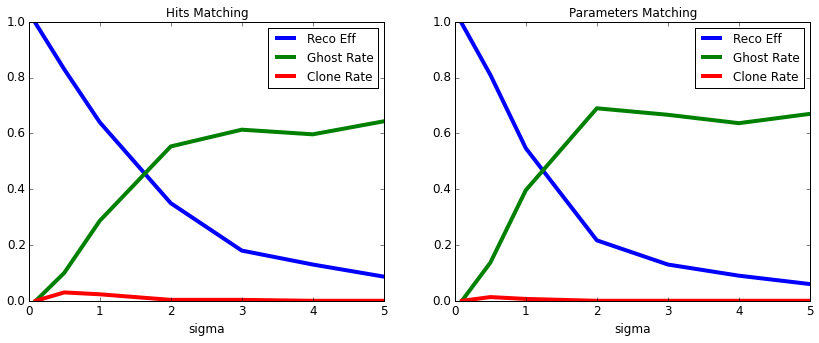

In [34]:
plot_report(report, 'sigma')

## Task 3

In this task change number of track in one event and explore how this influences on the quality metrics for the different models. Use **n_tracks** parameter of **straight_tracks_generator** function to change number of tracks per evetn. For each **n_tracks** value try to tune the models optimally. For the other parameters you can take your own values. 

Use the example below. Note, that that the Denby-Peterson method takes a lot of time.

Please, plot qualitiy curves from the example for the each model.

In [47]:
columns=['NTracks', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
report = pandas.DataFrame(columns=columns)

ns_tracks = [1, 2, 3, 4, 5]

for n_tracks in ns_tracks:
    
    events = straight_tracks_generator(n_events=100, n_tracks=n_tracks, n_noise=10, sigma=0.5)
    
    stm = SimpleTemplateMatching(8, 0.99)
    results_stm = get_quality_meatrics(events, model=stm)
    
    report.loc[len(report)] = [n_tracks] + list(results_stm[columns[1:]].mean(axis=0).values)

In [48]:
report

,NTracks,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,1,1.000,0.0100,0.000000,1.000000,0.0000,0.010
1,2,0.985,0.0100,0.000000,0.975000,0.0150,0.005
2,3,0.890,0.0500,0.006667,0.886667,0.0500,0.010
3,4,0.900,0.0425,0.015000,0.880000,0.0625,0.015
4,5,0.784,0.1400,0.018000,0.814000,0.1020,0.026


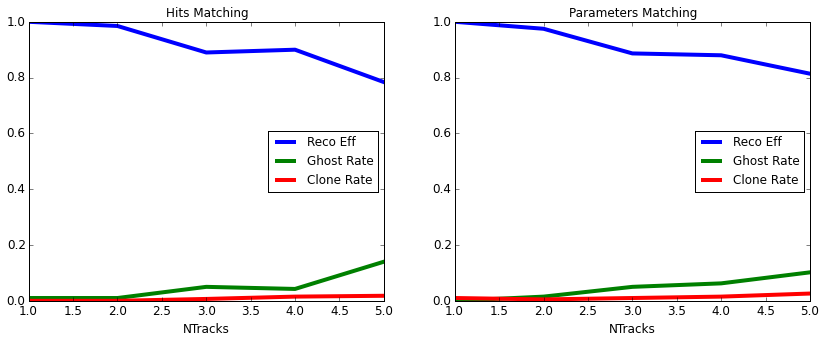

In [49]:
plot_report(report, 'NTracks')

## Task 4

In this task change number of wrong hits per one event and explore how this influences on the quality metrics for the different models. Use **n_noise** parameter of **straight_tracks_generator** function to change number of wrong hits per event. For each **n_noise** value try to tune the models optimally. For the other parameters you can take your own values. 

Use the example below. Note, that that the Denby-Peterson method takes a lot of time.

Please, plot qualitiy curves from the example for the each model.

In [38]:
columns=['NNoise', 'HmRecoEff', 'HmGhostRate', 'HmCloneRate', 'PmRecoEff', 'PmGhostRate', 'PmCloneRate']
report = pandas.DataFrame(columns=columns)

ns_noise = [0, 5, 10, 20, 30, 40, 50]

for n_noise in ns_noise:
    
    events = straight_tracks_generator(n_events=100, n_tracks=3, n_noise=n_noise, sigma=0.5)
    
    stm = SimpleTemplateMatching(8, 0.99)
    results_stm = get_quality_meatrics(events, model=stm)
    
    report.loc[len(report)] = [n_noise] + list(results_stm[columns[1:]].mean(axis=0).values)

In [39]:
report

,NNoise,HmRecoEff,HmGhostRate,HmCloneRate,PmRecoEff,PmGhostRate,PmCloneRate
0,0,0.926667,0.010000,0.000000,0.923333,0.013333,0.000000
1,5,0.923333,0.026667,0.013333,0.916667,0.046667,0.000000
2,10,0.940000,0.026667,0.016667,0.923333,0.053333,0.006667
3,20,0.916667,0.130000,0.023333,0.903333,0.133333,0.033333
4,30,0.866667,0.283333,0.026667,0.876667,0.273333,0.026667
5,40,0.790000,0.593333,0.030000,0.870000,0.436667,0.106667
6,50,0.733333,1.026667,0.013333,0.860000,0.780000,0.133333


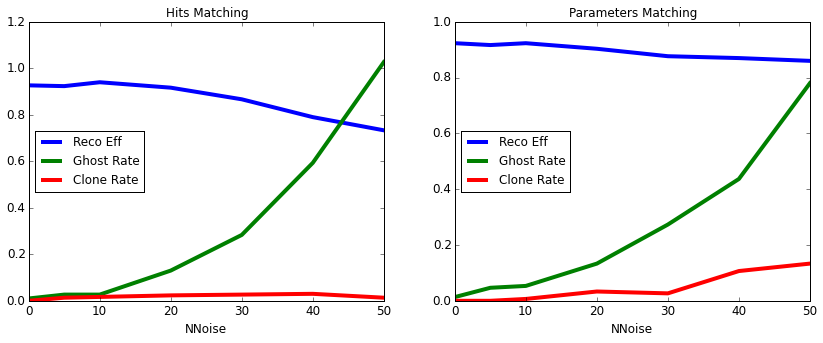

In [40]:
plot_report(report, 'NNoise')

## Task 5 (additional)

In this tacks repeat tasks 1-4 using circle tracks. For the data generation use the following generator:


The **circle_tracks_generator** function generates events with circle tracks (x - r)^2 + y^2 = r^2 and noise.

Parameters:

**n_events**: int, number of generated events.

**n_tracks**: int, number of generated tracks in each event. Tracks will have TrackIDs in range [0, inf).

**n_noise**: int, number of generated random noise hits. Noise hits will have TrackID -1.

**sigma**: float, track's hit generated with error which has normal distribution.
              Sigma is parameter of the distribution.
              
**intersection**: booleen, if False the tracks will not intersect.

**x_range**: tuple (min, max, step), range of x values of the hits.

**radius_range**: tuple (min, max, step), range of radius values of the tracks. (x - r)^2 + y^2 = r^2

In [11]:
from utils import circle_tracks_generator
events = circle_tracks_generator(n_events=100, n_tracks=3, n_noise=10, sigma=0.02, 
                                 x_range=(4, 10, 0.2), 
                                 radius_range=(6, 10, 0.5))

events.head()

,EventID,TrackID,X,y
0,0,0,4.0,5.618441
1,0,0,4.2,5.752007
2,0,0,4.4,5.816424
3,0,0,4.6,5.832549
4,0,0,4.8,5.886506


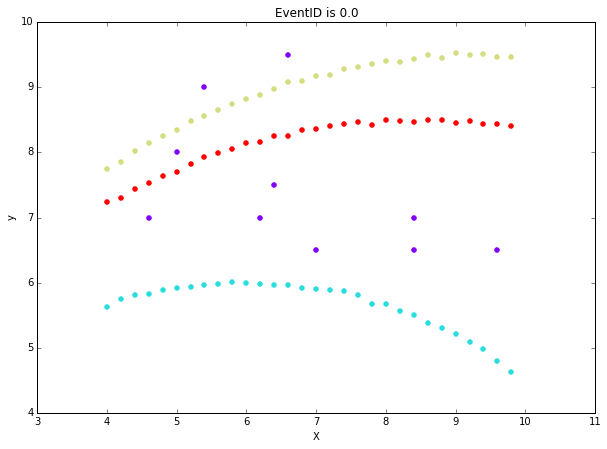

In [12]:
from utils import plot_circle_tracks
event = events[events.EventID == 0]
plot_circle_tracks(event)
plt.show()